In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Fonction pour appliquer le filtre passe-haut
def apply_high_pass_filter(image):
    # Convertir l'image en niveaux de gris
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Appliquer la transformation de Fourier
    f_transform = np.fft.fft2(gray)
    
    # Déplacer les composantes de fréquence zéro au centre
    f_transform_shifted = np.fft.fftshift(f_transform)
    
    # Créer un filtre passe-haut
    rows, cols = gray.shape
    crow, ccol = rows // 2, cols // 2
    f_transform_shifted[crow-30:crow+30, ccol-30:ccol+30] = 0
    
    # Déplacer les composantes de fréquence zéro vers le coin
    f_transform_unshifted = np.fft.ifftshift(f_transform_shifted)
    
    # Appliquer la transformation de Fourier inverse
    filtered_image = np.abs(np.fft.ifft2(f_transform_unshifted))
    
    return filtered_image

In [31]:
def process(thresholded_image):
    # Création des noyaux de différentes tailles
    small_kernel = np.ones((3, 3), np.uint8)  # Noyau Petit
    medium_kernel = np.ones((5, 5), np.uint8)  # Noyau Moyen
    big_kernel = np.ones((8, 8), np.uint8)  # Noyau Grand

    # Appliquer une opération de dilatation avec un noyau petit
    dilated_image_1 = cv2.dilate(thresholded_image, small_kernel, iterations=3)

    # Recréer le masque pour la couleur blanche
    white_mask = np.zeros(dilated_image_1.shape, dtype=np.uint8)
    white_mask[dilated_image_1 == 255] = 255

    # Appliquer une opération d'érosion pour réduire le bruit avec un noyau moyen
    erosion_image_1 = cv2.erode(white_mask, medium_kernel, iterations=3)
    """erosion_image_1 = cv2.erode(thresholded_image, medium_kernel, iterations=3)"""

    # Créer un masque pour la couleur blanche
    white_mask = np.zeros(erosion_image_1.shape, dtype=np.uint8)
    white_mask[erosion_image_1 == 255] = 255

    # Appliquer une opération de dilatation avec un noyau petit
    dilated_image_2 = cv2.dilate(white_mask, small_kernel, iterations=5)

    # Recréer le masque pour la couleur blanche
    white_mask = np.zeros(dilated_image_2.shape, dtype=np.uint8)
    white_mask[dilated_image_2 == 255] = 255

    # Appliquer une opération d'érosion pour réduire le bruit avec un noyau moyen
    erosion_image_2 = cv2.erode(white_mask, medium_kernel, iterations=3)

    # Recréer le masque pour la couleur blanche
    white_mask = np.zeros(erosion_image_2.shape, dtype=np.uint8)
    white_mask[erosion_image_2 == 255] = 255

    # Appliquer une opération de dilatation avec un noyau grand
    final_mask = cv2.dilate(white_mask, big_kernel, iterations=3)

    return final_mask

In [32]:
def get_mask(reference, current):
    # Appliquer le filtre passe-haut aux images
    filtered_reference = apply_high_pass_filter(reference)
    filtered_current = apply_high_pass_filter(current)

    # Soustraire les images filtrées
    difference_image = cv2.subtract(filtered_current, filtered_reference)

    # Appliquer un seuil pour binariser l'image
    threshold_value = 30
    _, thresholded_image = cv2.threshold(difference_image, threshold_value, 255, cv2.THRESH_BINARY)
    
    # Traitement de l'image binaire
    final_mask = process(thresholded_image)
    
    return final_mask

In [33]:
# Charger les images de référence et actuelle
reference_kitchen = cv2.imread("./Images/Cuisine/Reference.JPG")
current_kitchen = cv2.imread("./Images/Cuisine/IMG_6565.JPG")

final_mask = get_mask(reference_kitchen, current_kitchen)

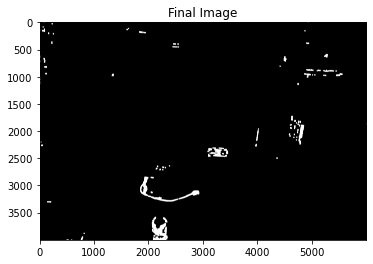

In [34]:
###  * * * * * * * * * * ** * * * * * * * * * *  ###
#""" Cette partie sert uniquement à l'affichage """#
"""
# Afficher les images avec les changements mis en évidence
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Afficher l'image seuillée et traitée
axes[0, 0].imshow(thresholded_image, cmap='gray')
axes[0, 0].set_title('Thresholded Image')

axes[0, 1].imshow(dilated_image_1, cmap='gray')
axes[0, 1].set_title('Dilated Image 1')

axes[0, 2].imshow(erosion_image_1, cmap='gray')
axes[0, 2].set_title('Erosion Image 1')

axes[1, 0].imshow(dilated_image_2, cmap='gray')
axes[1, 0].set_title('Dilated Image 2')

axes[1, 1].imshow(erosion_image_2, cmap='gray')
axes[1, 1].set_title('Erosion Image 2')

# Afficher le masque finale après réduction du bruit
axes[1, 2].imshow(final_mask, cmap='gray')
axes[1, 2].set_title('Final Image')
"""

# Afficher le masque finale après réduction du bruit
plt.imshow(final_mask, cmap='gray')
plt.title('Final Image')

plt.show()

#""" Cette partie sert uniquement à l'affichage """#
###  * * * * * * * * * * ** * * * * * * * * * *  ###

In [ ]:
"""
contours_list = [cv2.findContours(final_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0] for final_img in img_thresholds]
"""

hauteur_image = reference_kitchen.shape[0]  # Obtenez la hauteur de l'image
limite_hauteur = hauteur_image / 2  # La moitié de la hauteur de l'image
taille_minimale = 40000
taille_max =1000000
c=0

# Parcourir tous les contours détectés
for idx, contours in enumerate(contours_list):
    # Copier l'image d'origine pour dessiner dessus
    img_with_circles = img_changes[idx].copy()

    # Parcourir tous les contours détectés pour cette image
    for contour in contours:
        (x, y), radius = cv2.minEnclosingCircle(contour)
        center = (int(x), int(y))
        radius = int(radius)

        # Vérifier si le contour est en dessous de la moitié de la hauteur de l'image
        # et s'il a une taille minimale requise
        if y + radius > limite_hauteur and cv2.contourArea(contour) > taille_minimale and cv2.contourArea(contour) < taille_max:
            # Dessiner un cercle englobant pour chaque contour qui répond aux critères
            cv2.circle(img_with_circles, center, radius, (255, 0, 0), 5)
            c=c+1
    img_with_circlesA = cv2.cvtColor(img_with_circles, cv2.COLOR_BGR2RGB)
    plt.imshow(img_with_circlesA)
    plt.show()